# Clinical Text Classification
## TEAM -13 
### Team Members :
#### ARUN PRAKASH   -  CB.EN.U4AIE19014
#### C.R.ASSWIN     - CB.EN.U4AIE19016
#### DHARSHAN KUMAR - CB.EN.U4AIE19024
#### AVINASH DORA   - CB.EN.U4AIE19028 


Our Project consists of the following  steps:

* Data loading 
* Data Preprocessing
* Feature Engineering
* Model Selection
* Model training
* Model evaluation


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz


     |████████████████████████████████| 120.2 MB 27 kB/s 
     |████████████████████████████████| 6.0 MB 6.8 MB/s 
     |████████████████████████████████| 181 kB 37.0 MB/s 
     |████████████████████████████████| 457 kB 42.7 MB/s 
     |████████████████████████████████| 653 kB 35.8 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 10.1 MB 39.4 MB/s 
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.5.0-py3-none-any.whl size=120239502 sha256=1cc7d56a82ce7d7840d621dff8421cf1c7a70161cbd310b028ba8c7e51d9e67a
  Stored in directory: /root/.cache/pip/wheels/9d/69/01/c0a45e3fd3dfe3eec4fd1ae7d62a76e1909dba9f64f92f2428
Successfully built en-ner-bionlp13cg-md
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting un

In [3]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet'])
nltk.download('omw-1.4')
nltk.download('stopwords')
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sqlalchemy import create_engine

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
import string 
# from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,precision_score,recall_score

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import gradient_descent_v2 
# from keras.optimizers import SGD # outdated
from tensorflow.keras.optimizers import RMSprop
from keras.initializers import VarianceScaling

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
SEQUENCE_MODEL = False
MAX_TOKENS = 20000
MAX_LENGTH = 1500
USE_GROVE  = True

## 1. Data Loading


 the code below loads the open source clinical text classification dataset into memory as Pandas DataFrame:

In [5]:
data = pd.read_csv("/content/gdrive/MyDrive/DLforSIP/NLP/mtsamples.csv", index_col=0)
print(data.shape)
data.head()

(4999, 5)


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
data['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

## 2. Data Exploration



In [7]:
filtered_data = data[['transcription', 'medical_specialty']]
filtered_data.loc[:, 'medical_specialty'] = filtered_data['medical_specialty'].apply(lambda x:str.strip(x))
mask = (filtered_data['medical_specialty'] == 'SOAP / Chart / Progress Notes') | \
       (filtered_data['medical_specialty'] == 'Office Notes') | \
       (filtered_data['medical_specialty'] == 'Consult - History and Phy.') | \
       (filtered_data['medical_specialty'] == 'Emergency Room Reports') | \
       (filtered_data['medical_specialty'] == 'Discharge Summary') | \
       (filtered_data['medical_specialty'] == 'Letters') | \
       (filtered_data['medical_specialty'] == 'Pain Management')

filtered_data = filtered_data[~mask]

mask = filtered_data['medical_specialty'] == 'Neurosurgery'
filtered_data.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data['medical_specialty'] == 'Nephrology'
filtered_data.loc[mask, 'medical_specialty'] = 'Urology'

filtered_data['medical_specialty'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Surgery                       1103
Cardiovascular / Pulmonary     372
Orthopedic                     355
Neurology                      317
Radiology                      273
General Medicine               259
Urology                        239
Gastroenterology               230
Obstetrics / Gynecology        160
ENT - Otolaryngology            98
Hematology - Oncology           90
Ophthalmology                   83
Pediatrics - Neonatal           70
Psychiatry / Psychology         53
Podiatry                        47
Dermatology                     29
Cosmetic / Plastic Surgery      27
Dentistry                       27
Physical Medicine - Rehab       21
Sleep Medicine                  20
Endocrinology                   19
Bariatrics                      18
IME-QME-Work Comp etc.          16
Chiropractic                    14
Rheumatology                    10
Diets and Nutritions            10
Speech - Language                9
Autopsy                          8
Lab Medicine - Patho

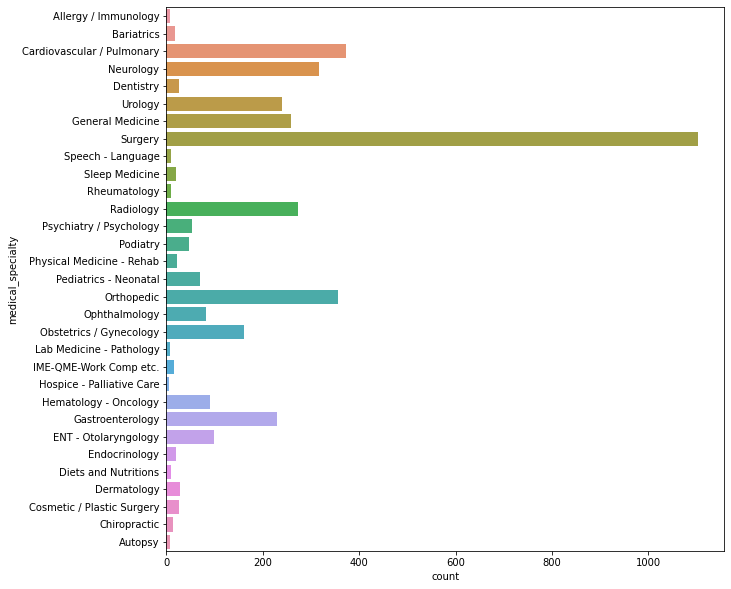

In [41]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data )
plt.show()

In [8]:
data_categories  = filtered_data.groupby(filtered_data['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 100)
filtered_data_categories['medical_specialty'].value_counts()

Surgery                       1103
Cardiovascular / Pulmonary     372
Orthopedic                     355
Neurology                      317
Radiology                      273
General Medicine               259
Urology                        239
Gastroenterology               230
Obstetrics / Gynecology        160
Name: medical_specialty, dtype: int64

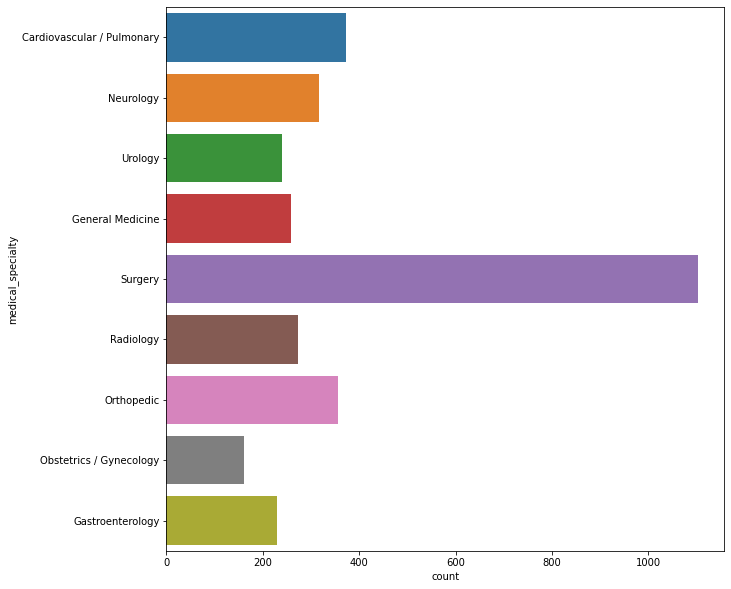

In [42]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [9]:
data = filtered_data_categories.sample(frac=1.0) # shuffling data to avoid artificial patterns
data.shape

(3308, 2)

## 2. Data Preprocessing



In order to handle missing data, and reduce the size of vocabulary and training data, the following common data preprocessing steps are normally applied to a text feature (e.g., the transcription feature) for text classification:

* handle missing data
* standardize text
* tokenize text
* remove stopwords
* stemming
* lemmatize

### 2.1 Handle missing data


In [10]:
print('number of missing entries: ', data['transcription'].isna().sum())
df = data.dropna(subset=['transcription'])
df.shape

number of missing entries:  29


(3279, 2)

In [11]:
df.head()

,transcription,medical_specialty
258,"PROCEDURE:, Total hip replacement.,PROCEDURE ...",Surgery
918,"DELIVERY NOTE: , The patient came in around 03...",Surgery
4668,"EXAM: , Single frontal view of the chest.,HIST...",Cardiovascular / Pulmonary
3682,"PREOPERATIVE DIAGNOSES,1. Adrenal mass, right...",Gastroenterology
266,"PREOPERATIVE DIAGNOSES,1. Recurrent tonsillit...",Surgery


### 2.2 Extract Medical Entities 

In [12]:
import spacy
import en_ner_bionlp13cg_md

nlp = en_ner_bionlp13cg_md.load()

def medical_entities( text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
    return ' '.join(entities)

df['transcription'] = df['transcription'].apply(medical_entities)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### 2.3 Standardize text
There are two common steps to standardize text:
* change text to lower case: this helps to avoid the effort for a machine learning model to learn the case of characters.
* remove punctuation: this helps to reduce the size of vocabulary



In [13]:
text = df['transcription'].values[0]
text

'patient supine patient trochanter subcutaneous tissues gluteus maximus trochanter capsule femoral neck femoral head femoral head femur subchondral bone shell pelvis extra bone lateral intramedullary hole femur femur head and neck extension-external stem head stem cement canal stem joint bone gluteus maximus subcutaneous tissues skin patient'

In [14]:
# change to lower case and remove punctuation
text = text.lower().translate(str.maketrans('', '', string.punctuation))
text

'patient supine patient trochanter subcutaneous tissues gluteus maximus trochanter capsule femoral neck femoral head femoral head femur subchondral bone shell pelvis extra bone lateral intramedullary hole femur femur head and neck extensionexternal stem head stem cement canal stem joint bone gluteus maximus subcutaneous tissues skin patient'

In [15]:
# change to lower case and remove punctuation
text = text.lower().translate(str.maketrans('', '', string.punctuation))
text

'patient supine patient trochanter subcutaneous tissues gluteus maximus trochanter capsule femoral neck femoral head femoral head femur subchondral bone shell pelvis extra bone lateral intramedullary hole femur femur head and neck extensionexternal stem head stem cement canal stem joint bone gluteus maximus subcutaneous tissues skin patient'

### 2.4 Tokenize text

This helps to divide a text into elements of vocabulary. word-level (1-gram) tokenization is commonly used if text is treated as sequence of words. Word-level tokenization also enables the activities of removing stopwords, stemming, and lemmatization. 

 

In [16]:
from nltk.tokenize import word_tokenize

# divide string into individual words
tokens = word_tokenize(text)
tokens

['patient',
 'supine',
 'patient',
 'trochanter',
 'subcutaneous',
 'tissues',
 'gluteus',
 'maximus',
 'trochanter',
 'capsule',
 'femoral',
 'neck',
 'femoral',
 'head',
 'femoral',
 'head',
 'femur',
 'subchondral',
 'bone',
 'shell',
 'pelvis',
 'extra',
 'bone',
 'lateral',
 'intramedullary',
 'hole',
 'femur',
 'femur',
 'head',
 'and',
 'neck',
 'extensionexternal',
 'stem',
 'head',
 'stem',
 'cement',
 'canal',
 'stem',
 'joint',
 'bone',
 'gluteus',
 'maximus',
 'subcutaneous',
 'tissues',
 'skin',
 'patient']

### 2.5 Remove Stopwords

this helps to reduce the size of vocabulary without compromise of model prediction accuracy. 

In [17]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

clean_tokens = []
for tok in tokens:
    tok = tok.strip() # remove space
    if tok not in english_stopwords:
        clean_tokens.append(tok)
        
clean_tokens

['patient',
 'supine',
 'patient',
 'trochanter',
 'subcutaneous',
 'tissues',
 'gluteus',
 'maximus',
 'trochanter',
 'capsule',
 'femoral',
 'neck',
 'femoral',
 'head',
 'femoral',
 'head',
 'femur',
 'subchondral',
 'bone',
 'shell',
 'pelvis',
 'extra',
 'bone',
 'lateral',
 'intramedullary',
 'hole',
 'femur',
 'femur',
 'head',
 'neck',
 'extensionexternal',
 'stem',
 'head',
 'stem',
 'cement',
 'canal',
 'stem',
 'joint',
 'bone',
 'gluteus',
 'maximus',
 'subcutaneous',
 'tissues',
 'skin',
 'patient']

The data preprocessing steps above can be combined into one function to clean up a text string:

In [18]:
def clean_text(text):
    # get English stopwords
    english_stopwords = set(stopwords.words('english'))
    
    # change to lower case and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # divide string into individual words
    tokens = word_tokenize(text)
    
    # create Stemmer object
    stemmer = PorterStemmer()
    
    # change words to its root format
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        tok = tok.strip() # remove space
        if tok not in english_stopwords:
            clean_tok = lemmatizer.lemmatize(tok) # lemmatizition
            clean_tok = stemmer.stem(clean_tok) # Stemming
            clean_tokens.append(clean_tok)

    return " ".join(clean_tokens) # combine tokens into one string when necessary

text = df['transcription'].values[0]
clean_tokens = clean_text(text)
clean_tokens

'patient supin patient trochant subcutan tissu gluteu maximu trochant capsul femor neck femor head femor head femur subchondr bone shell pelvi extra bone later intramedullari hole femur femur head neck extensionextern stem head stem cement canal stem joint bone gluteu maximu subcutan tissu skin patient'

## 3. Feature Engineering

Once a text feature is preprocessed, each text (document) needs to be encoded as a vector of numbers (called vectorization) since machine learning and deep learning models only understand numbers. The selection of encoding method depends on how text is interpreted.

### 3.1 TF-IDF Vcetorization
the TF-IDF vetorization encodes one text as a sparse vector of the length of vocabulary. The major difference is that TF-IDF encoded vector records not only the presence information of the corresponding words/tokens in the vocabulary but also the token frequency (TF) weighted by the inverted document frequency (IDF). Because of this, TF-IDF encoded vector has more prediction power then Muti-Hot encoding.

The following code shows how to use TF-IDF to encode a given text string as one sparse vector:

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF encoding
text_array = df['transcription'].values[0:1]
tfidf = TfidfVectorizer(tokenizer=clean_text, ngram_range=(1,3))
tfidf_encoded_text = tfidf.fit_transform(text_array)

features_arr=tfidf_encoded_text.toarray()
tfidf_encoded_text.todense()

matrix([[0.4771067 , 0.03253   , 0.03253   , 0.03253   , 0.02168667,
         0.01084333, 0.02168667, 0.02168667, 0.06506   , 0.06506   ,
         0.02168667, 0.02168667, 0.05421667, 0.04337334, 0.01084333,
         0.01084333, 0.01084333, 0.01084333, 0.01084333, 0.01084333,
         0.01084333, 0.02168667, 0.02168667, 0.02168667, 0.02168667,
         0.03253   , 0.02168667, 0.01084333, 0.09759001, 0.01084333,
         0.01084333, 0.03253   , 0.04337334, 0.04337334, 0.02168667,
         0.02168667, 0.21686668, 0.01084333, 0.01084333, 0.04337334,
         0.04337334, 0.01084333, 0.01084333, 0.01084333, 0.01084333,
         0.05421667, 0.02168667, 0.01084333, 0.02168667, 0.01084333,
         0.01084333, 0.01084333, 0.01084333, 0.04337334, 0.01084333,
         0.03253   , 0.02168667, 0.02168667, 0.06506   , 0.03253   ,
         0.01084333, 0.02168667, 0.03253   , 0.03253   , 0.10843334,
         0.02168667, 0.01084333, 0.01084333, 0.01084333, 0.01084333,
         0.03253   , 0.02168667, 0

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

def tfidf_pca(X_feature, y_label):
    '''
    X_feature = df['transcription'].values
    y_label = df['medical_specialty'].values
    '''
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_label)

    tfidf = TfidfVectorizer(tokenizer=clean_text, ngram_range=(1,3))
    pca = PCA(n_components=0.95)
    X_tfidf = tfidf.fit_transform(X_feature)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    smote_over_sample = SMOTE(sampling_strategy='minority')

    X, y = smote_over_sample.fit_resample(X_pca, y_int.tolist())

    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

def VmD_func(X_feature, y_label):
    '''
    X_feature = df['transcription'].values
    y_label = df['medical_specialty'].values
    '''
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_label)
    y_int_1=y_int.tolist()
    tfidf = TfidfVectorizer(tokenizer=clean_text, ngram_range=(1,3))
    #pca = PCA(n_components=0.95)
    X_tfidf = tfidf.fit_transform(X_feature)
    features_arr=X_tfidf.toarray()
    #X_pca = pca.fit_transform(X_tfidf.toarray())

    #smote_over_sample = SMOTE(sampling_strategy='minority')

    X = []
    for i in features_arr:
        X.append(maxvdm(i))

    #X, y = smote_over_sample.fit_resample(features_arr, y_int.tolist())

   

    X = np.array(X)
    y = np.array(y_int_1)


    
    return X, y

## VMD

In [21]:
pip install vmdpy

In [22]:
from vmdpy import VMD

In [26]:
import scipy.signal
def energy(u):
# Estimate PSD `S_xx_welch` at discrete frequencies `f_welch`
    f_welch, S_xx_welch = scipy.signal.welch(u)

    # Integrate PSD over spectral bandwidth
    # to obtain signal power `P_welch`
    df_welch = f_welch[1] - f_welch[0]
    return np.sum(S_xx_welch) * df_welch

In [23]:
def maxvdm(f):
    alpha = 2     
    tau = 0.            
    K = 2       
    DC = 0             
    init = 1           
    tol = 1e-7  
    u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol) 
    energy_array=[]
    for i in u:
        energy_array.append(energy(i))
    ind = np.argmax(energy_array)
    return u[ind]

In [ ]:
#X_data = []
#for i in features_arr:
#    X_data.append(maxvdm(i))

### 3.2 Word Embedding

If a text is treated as a sequence of words, we can use the following common methods to convert each word in a text as one vector and the whole text as an array of vectors:

* Word Embedding: encode each word as a dense vector of much shorter length (typically 250, 500, or 1,000) 


Given a text/document, there are two steps to map it to a dense vector of a given size:
* Step 1: convert the text into a vector of word/token indicies in the vocabulary
* Step 2: use a custom trained or pre-trained word embedding algorithm (e.g., Word2Vec and GloVe) to convert each word index into a dense vector of float numbers



In [ ]:
from tensorflow.keras import layers

def indecies_vectorize(X_feature, y_label, max_length = 1500, max_tokens = MAX_TOKENS):
    '''
    X_feature: df['transcription'].values
    max_length: maximum number of words in one text/document
    max_tokens: the length of vocabulary
    '''
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_label)
    
    text_vectorization = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_length,
    )

    # training the text vectorization object
    text_vectorization.adapt(X_feature) 
    # convert preprocessed training text into anrray of integers/indecies
    indecies_array = text_vectorization(X_feature) 
    
    smote_over_sample = SMOTE(sampling_strategy='minority')
    X, y = smote_over_sample.fit_resample(indecies_array, y_int)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

The code below shows how to use a custom trained word embedding layer from Keras to encode a vector of word indices as a sequence of dense vectors of length 250.

In [ ]:
import keras


def embedd():
  # create input layer
    inputs = keras.Input(shape=(None,), dtype="int64")

# add word embedding layer
    embedded = layers.Embedding(input_dim=MAX_TOKENS, output_dim=256, mask_zero=True)(inputs)
  

### 3.3 Positional Embedding 



In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

The table below is a summary of the selections of different text encoding methods.

| Text Treatment Methods| Text Encoding Methods|
|:---|:---|
|Bag of Words |TF-IDF |
|Sequence of Words |Word Embedding |
|Sequence of Words |Positional Embedding |

## 4. Model Selection

Similarly to the selection of text encoding methods, the selection of a machine learning or deep learning model for text classification depends on how text is encoded. Specifically, we can select a model as shown in the table below:

|Text Encoding Methods |Machine Learning or Deep Learning Models |
|:---|:---|
|TF-IDF |Any non-sequence classification model such as Logistic Regression, XGBoost, Random Forest, MLP, etc. |
|Multi-Hot |Any non-sequence classification model such as Logistic Regression, XGBoost, Random Forest, MLP, etc. |
|Word Embedding |Any sequence classification model such as LSTM, GRU, etc. |
|One-Hot Encoding |Any sequence classification model such as LSTM, GRU, etc. |
|Positional Embedding |Transformer |

The TransformerEncoder class below implements an attention-based transformer 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


## 5. Model Training

Typically we need to split the dataset into training, validation, and testing subsets before model training begins. For simplicity, the dataset is only split into two subsets in this article: one for model training and the other for model testing/evaluation.  

In [ ]:
from sklearn.model_selection import train_test_split

X_feature = df['transcription'].values
y_label = df['medical_specialty'].values

if SEQUENCE_MODEL:
    X, y = indecies_vectorize(X_feature, y_label)
else:   
    X, y = tfidf_pca(X_feature, y_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3159, 1500), (1053, 1500), (3159,), (1053,))

## Normal and vmd compare Training

In [28]:
from sklearn.model_selection import train_test_split

X_feature = df['transcription'].values
y_label = df['medical_specialty'].values

if SEQUENCE_MODEL:
    X, y = indecies_vectorize(X_feature, y_label)
else:   
    X, y = VmD_func(X_feature, y_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

/usr/local/lib/python3.7/dist-packages/vmdpy/vmdpy.py:105: RuntimeWarning: invalid value encountered in double_scalars
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/usr/local/lib/python3.7/dist-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in double_scalars
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)


((2459, 8380), (820, 8380), (2459,), (820,))

### 5.1 Non-Sequence Modeling with TF-IDF

In this article I use Random Forest with TF-IDF encoding to demonstrate how to perform non-sequence modeling for text classification (see the code below).

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

if not SEQUENCE_MODEL:
    rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10)
    rf_clf.fit(X_train, y_train)


In [33]:
from sklearn.linear_model import LogisticRegression

if not SEQUENCE_MODEL:
    logistic_clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1)
    logistic_clf.fit(X_train, y_train)


In [34]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

if not SEQUENCE_MODEL:
    multi_class_clf = MultiOutputClassifier(KNeighborsClassifier())
    y_train = y_train.reshape(-1, 1)
    multi_class_clf.fit(X_train, y_train)


### 5.2 Sequence Modeling Using LSTM with Word Embedding

In this article I use LSTM with custom word embedding to demonstrate how to perform sequence modeling for text classification (see code below).

In [ ]:
import numpy as np
path_to_glove_file = "/content/gdrive/MyDrive/DLforSIP/NLP/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

text_vectorization = layers.TextVectorization(
        max_tokens=MAX_TOKENS,
        output_mode="int",
        output_sequence_length=MAX_LENGTH,
    )

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((MAX_TOKENS, embedding_dim))
for word, i in word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    MAX_TOKENS,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [ ]:
import gc
gc.collect()

1027

In [ ]:
import keras

def create_lstm_model(embedding_layer = None):
    # create input layer
    inputs = keras.Input(shape=(None,), dtype="int64")

    # add word embedding layer
    if embedding_layer is not None:
        embedded = embedding_layer(inputs)
    else:
        embedded = layers.Embedding(input_dim=MAX_TOKENS, output_dim=256, mask_zero=True)(inputs)

    # add LSTM layer
    x = layers.Bidirectional(layers.LSTM(32))(embedded)

    # add dropout layer
    x = layers.Dropout(0.5)(x)

    # add output layer
    outputs = layers.Dense(9, activation="softmax")(x)

    # combine all layers into one model
    lstm_model = keras.Model(inputs, outputs)

    # specifiy optimizer, loss, and metrics for the model
    lstm_model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # print the summay of the model architecture
    lstm_model.summary()
    
    return lstm_model


if SEQUENCE_MODEL:
    if USE_GROVE:
        lstm_model = create_lstm_model(embedding_layer)
    else:
        lstm_model = create_lstm_model()
    
    # define callback function
    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                        save_best_only=False)
    ]

    # train model
    lstm_model.fit(X_train, y_train, epochs=10, callbacks=callbacks)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 9)                 585       
                                                                 
Total params: 2,034,633
Trainable params: 34,633
Non-trainable params: 2,000,000
____________________________________________

In [ ]:
import gc
gc.collect()

1474

### 5.3 Sequence Modeling with Transformer

Recently the attention-based Transformer algorithm becomes a preferred algorithm over LSTM for sequence modeling. The code below uses the Transformer algorithm with positional embedding 

In [ ]:
def create_transformer():

    vocab_size = 20000
    sequence_length = 1500
    embed_dim = 256
    num_heads = 2
    dense_dim = 32

    inputs = keras.Input(shape=(None,), dtype="int64")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(9, activation="softmax")(x)
    transformer_model = keras.Model(inputs, outputs)
    transformer_model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    transformer_model.summary()
    
    return transformer_model

if SEQUENCE_MODEL:
    transformer_model = create_transformer()

    callbacks = [
        keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                        save_best_only=False)
    ]

    transformer_model.fit(X_train, y_train, epochs=30, callbacks=callbacks)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5504000   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

## 6. Model Evaluation


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_) 
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax)

### 6.1 Non-Sequence Model Evaluation

Accuracy score:  0.3371320037986705
F1 score:  0.30316876310262186


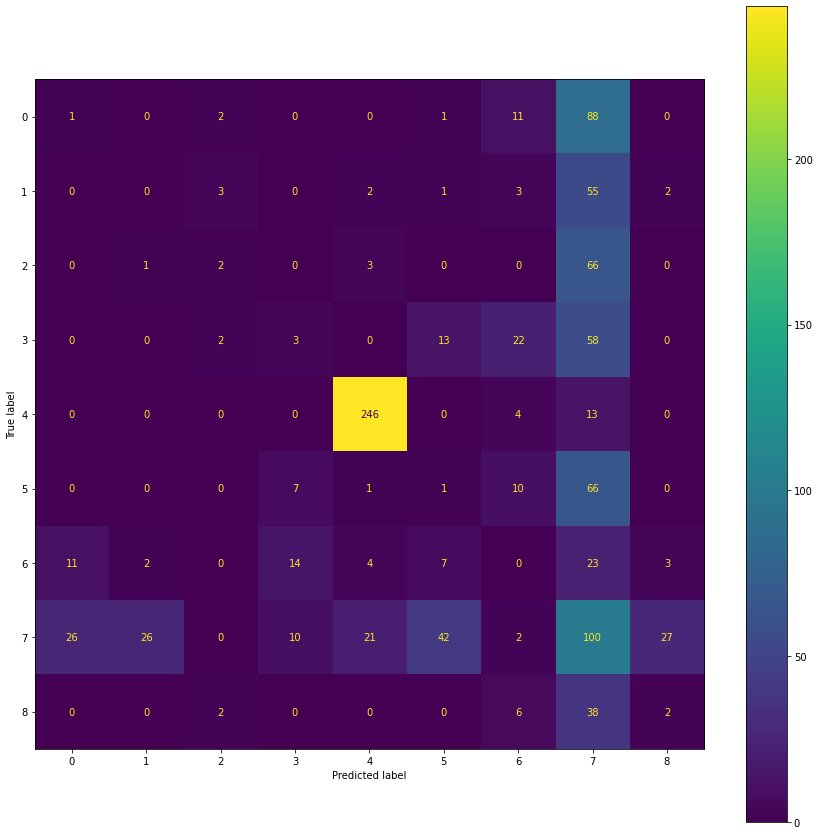

In [ ]:
if not SEQUENCE_MODEL:
    y_pred = rf_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy score: ', acc_score)

    prec_score = precision_score(y_test, y_pred)
    print('Precision score: ', acc_score)

    rec_score = recall_score(y_test, y_pred)
    print('Recall score: ', rec_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)

logistic_clf Accuracy score:  0.5802469135802469
logistic_clf F1 score:  0.5684990311541539


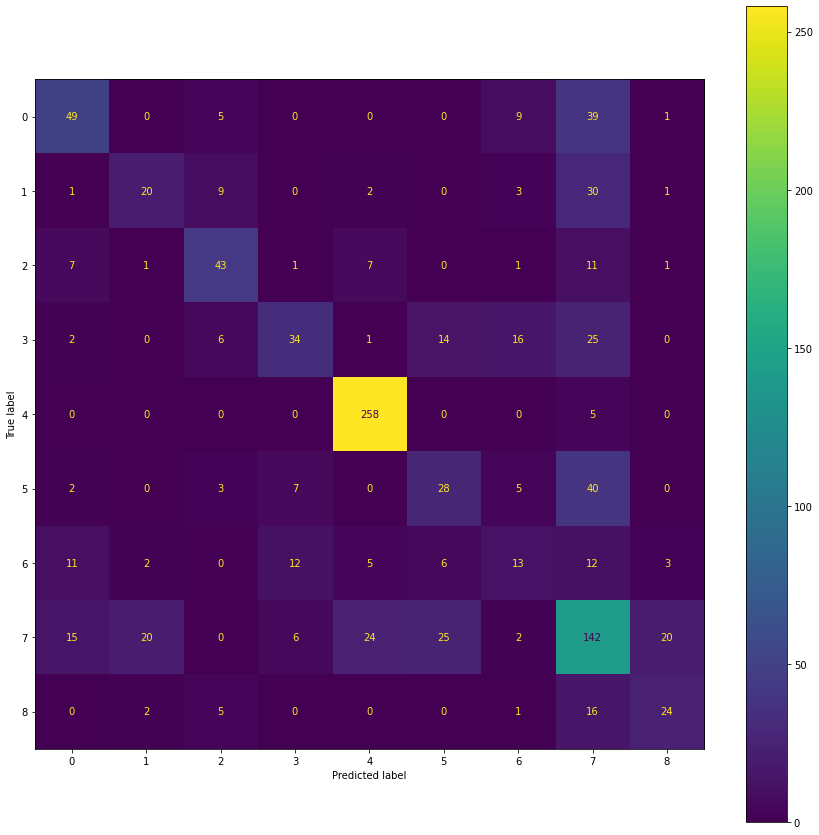

In [ ]:
if not SEQUENCE_MODEL:
    y_pred = logistic_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('logistic_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('logistic_clf F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=logistic_clf.classes_)


multi_class_clf Accuracy score:  0.4624881291547958
multi_class_clf F1 score:  0.4260172639053519


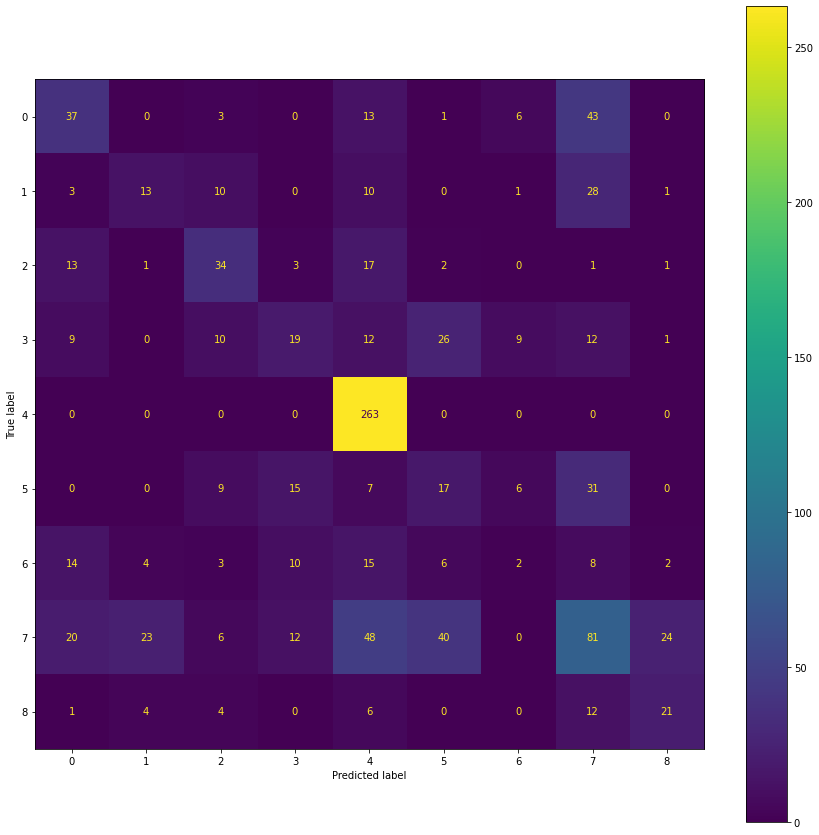

In [ ]:
if not SEQUENCE_MODEL:
    y_test = y_test.reshape(-1, 1)

    y_pred = multi_class_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('multi_class_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('multi_class_clf F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=multi_class_clf.classes_)


### 6.2 Sequence Model Evaluation

In [ ]:
if SEQUENCE_MODEL:
    y_pred = lstm_model.predict(X_test)
    y_pred_labels = np.apply_along_axis(np.argmax, 1, y_pred) 

    acc_score = accuracy_score(y_test, y_pred_labels)
    print('lstm_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print('lstm_clf F1 score: ', f1)
else:
  print("Not a Sequence Model")    

lstm_clf Accuracy score:  0.2564102564102564
lstm_clf F1 score:  0.17517796392019483


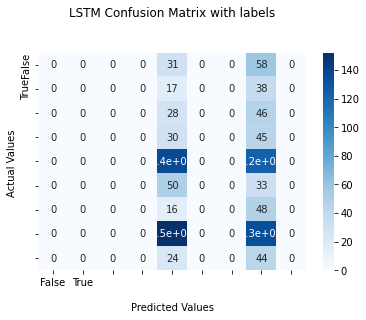

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred_labels)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
if SEQUENCE_MODEL:
    y_pred = transformer_model.predict(X_test)
    y_pred_labels = np.apply_along_axis(np.argmax, 1, y_pred) 

    acc_score = accuracy_score(y_test, y_pred_labels)
    print('transformer_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print('transformer_clf F1 score: ', f1)
   # plot_confusion_matrix(y_test, y_pred,labels=multi_class_clf.classes_)
else:
  print("Not a Sequence Model")   

transformer_clf Accuracy score:  0.38271604938271603
transformer_clf F1 score:  0.3923869483927772


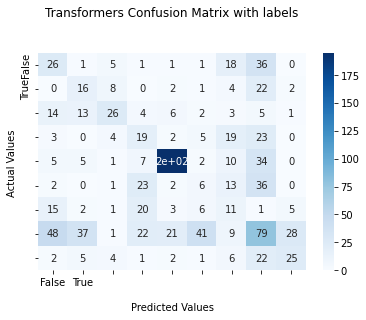

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred_labels)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Transformers Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Summary of Model Evaluation Results

|Model |Accuracy |F1 Score |
|:---|:---|:---|
|Logistic Regression |0.5802 |0.5684|
|Multi-Output Classifier |0.4624 |0.4260 |
|Random Forest |0.3371 |0.3031 |
|LSTM |0.4226 |0.4326 |
|Transformer |0.3912 |0.4028 |

In [ ]:
### VMD outputs

### VMD 

Accuracy score:  0.3378048780487805
Precision score:  0.3378048780487805
Recall score:  0.3378048780487805
F1 score:  0.21857792749544855


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


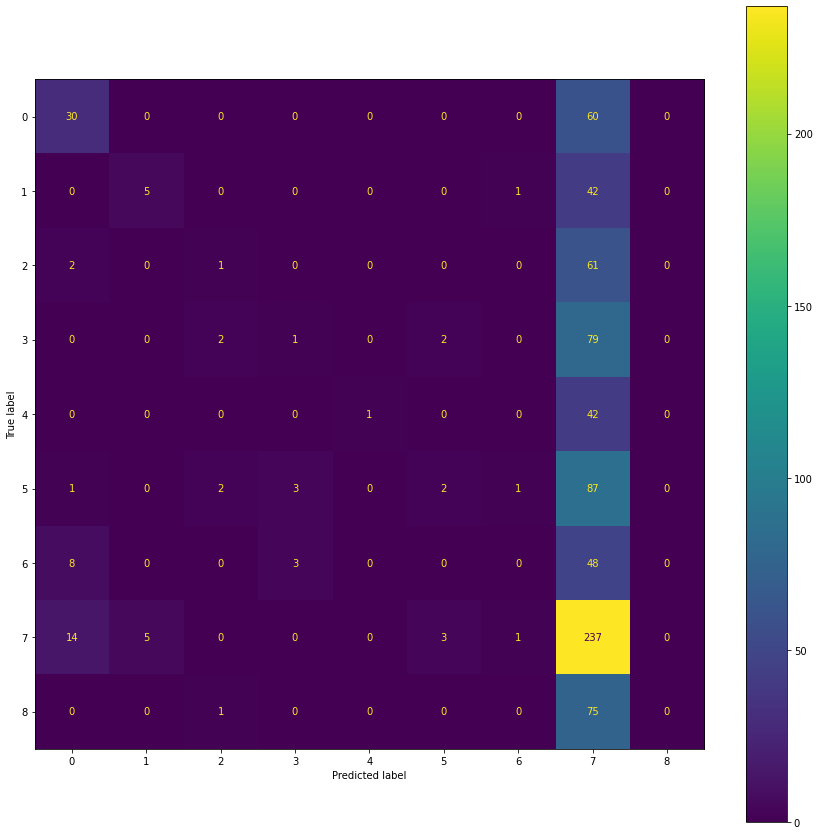

In [40]:
#LR
if not SEQUENCE_MODEL:
    y_pred = logistic_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy score: ', acc_score)

    prec_score = precision_score(y_test, y_pred, average='weighted')
    print('Precision score: ', acc_score)

    rec_score = recall_score(y_test, y_pred, average='weighted')
    print('Recall score: ', rec_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=logistic_clf.classes_)

Accuracy score:  0.22560975609756098
Precision score:  0.22560975609756098
Recall score:  0.22560975609756098
F1 score:  0.189817242621263


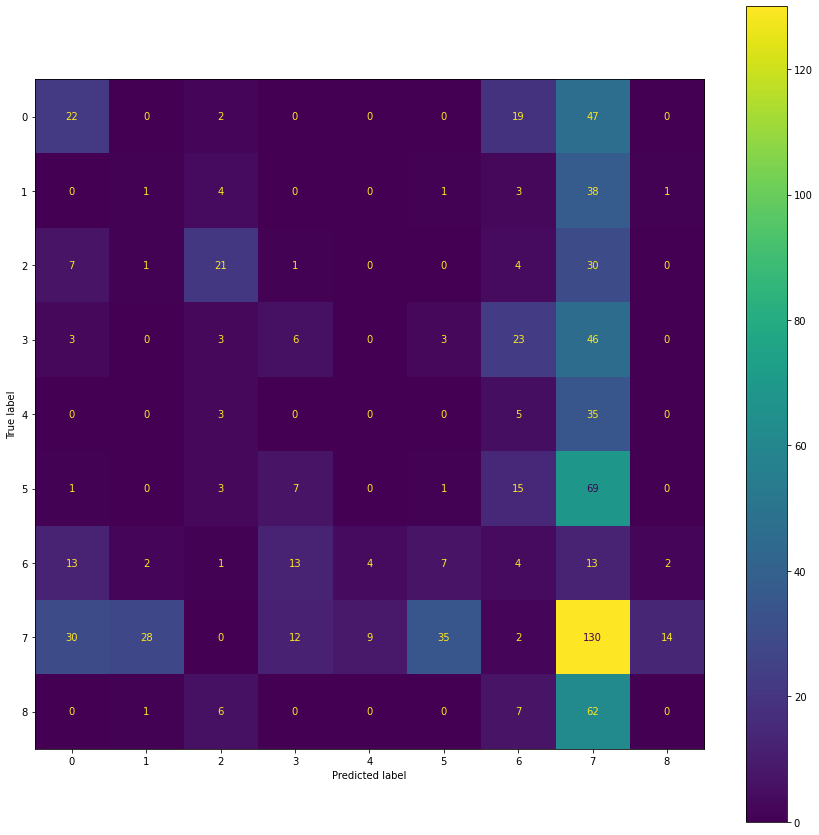

In [38]:
# RF
if not SEQUENCE_MODEL:
    y_pred = rf_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy score: ', acc_score)

    prec_score = precision_score(y_test, y_pred, average='weighted')
    print('Precision score: ', acc_score)

    rec_score = recall_score(y_test, y_pred, average='weighted')
    print('Recall score: ', rec_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)

Accuracy score:  0.348780487804878
Precision score:  0.348780487804878
Recall score:  0.348780487804878
F1 score:  0.3426816789566413


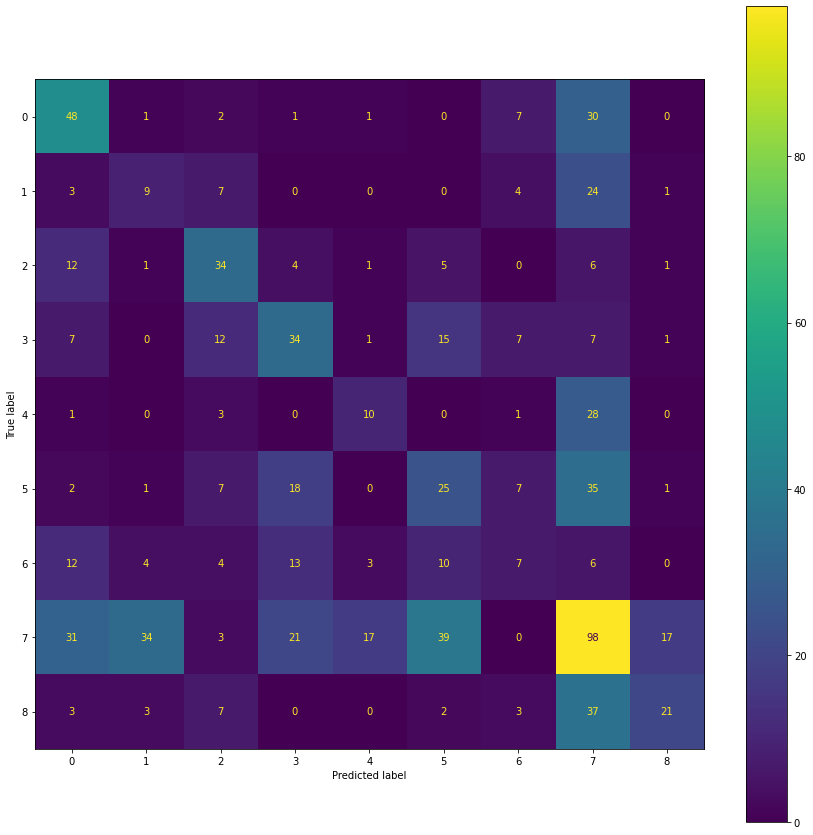

In [39]:
if not SEQUENCE_MODEL:
    y_test = y_test.reshape(-1, 1)

    y_pred = multi_class_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy score: ', acc_score)

    prec_score = precision_score(y_test, y_pred, average='weighted')
    print('Precision score: ', acc_score)

    rec_score = recall_score(y_test, y_pred, average='weighted')
    print('Recall score: ', rec_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=multi_class_clf.classes_)